In [1]:
!pip install plotly


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [6]:
from google.colab import files
uploaded = files.upload()

Saving olist_customers_dataset.csv to olist_customers_dataset.csv
Saving olist_order_items_dataset.csv to olist_order_items_dataset.csv
Saving olist_order_reviews_dataset.csv to olist_order_reviews_dataset.csv
Saving olist_orders_dataset.csv to olist_orders_dataset.csv
Saving olist_products_dataset.csv to olist_products_dataset.csv


In [9]:
#  Load datasets
orders = pd.read_csv("olist_orders_dataset.csv")
items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

#  Merge datasets
df = orders.merge(items, on='order_id', how='left') \
           .merge(products, on='product_id', how='left') \
           .merge(customers, on='customer_id', how='left') \
           .merge(reviews, on='order_id', how='left')

#  Convert time columns
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['month'] = df['order_purchase_timestamp'].dt.to_period('M')


In [10]:
monthly_sales = df.groupby('month')['price'].sum().reset_index()
monthly_sales['month'] = monthly_sales['month'].astype(str)

fig = px.line(monthly_sales, x='month', y='price', title='Monthly Sales Trend', markers=True)
fig.show()


In [11]:
top_products = df.groupby('product_id')['price'].sum().nlargest(10).reset_index()
fig = px.bar(top_products, x='product_id', y='price', title='Top 10 Products by Revenue')
fig.show()


In [12]:
customer_orders = df.groupby('customer_id')['order_id'].nunique().reset_index(name='order_count')
repeat_customers = customer_orders[customer_orders['order_count'] > 1]

print(f"Total customers: {customer_orders.shape[0]}")
print(f"Repeat customers: {repeat_customers.shape[0]}")
print(f"Repeat customer rate: {100 * repeat_customers.shape[0] / customer_orders.shape[0]:.2f}%")


Total customers: 99441
Repeat customers: 0
Repeat customer rate: 0.00%


In [13]:
review_scores = df['review_score'].value_counts().sort_index()
fig = px.bar(review_scores, title='Review Score Distribution', labels={'index': 'Review Score', 'value': 'Count'})
fig.show()


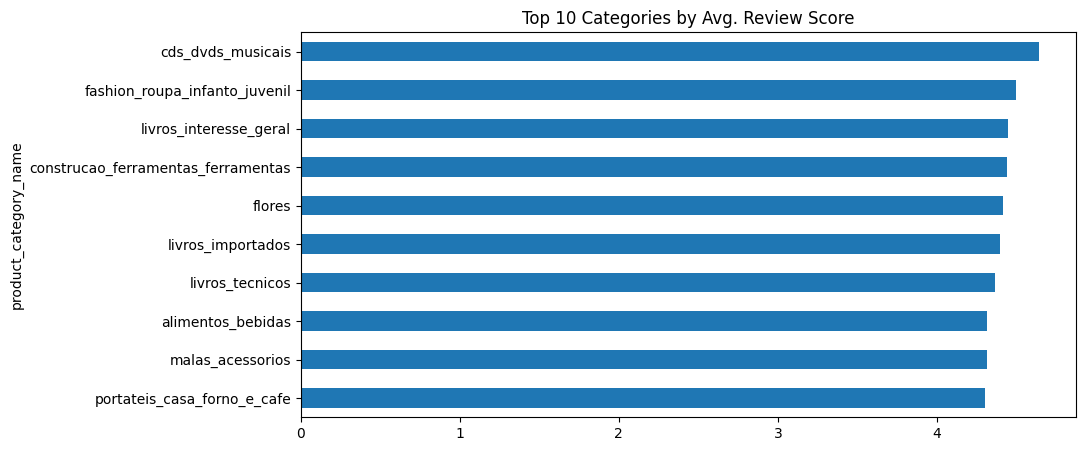

In [14]:
avg_review = df.groupby('product_category_name')['review_score'].mean().sort_values(ascending=False).head(10)
avg_review.plot(kind='barh', title='Top 10 Categories by Avg. Review Score', figsize=(10,5))
plt.gca().invert_yaxis()
plt.show()


In [27]:
import pandas as pd
import numpy as np

# Load your datasets (assuming already uploaded or mounted)
orders = pd.read_csv("olist_orders_dataset.csv")
items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

# Merge datasets
df = orders.merge(items, on='order_id', how='left') \
           .merge(products, on='product_id', how='left') \
           .merge(customers, on='customer_id', how='left') \
           .merge(reviews, on='order_id', how='left')

# Convert datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Snapshot date for Recency calculation
snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# RFM Table
rfm_df = df.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'nunique',
    'price': 'sum'
}).reset_index()

rfm_df.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

# Bulletproof binning function
def bin_score(series, bins=4, reverse=False):
    unique_vals = series.nunique()
    actual_bins = min(bins, unique_vals)
    if actual_bins <= 1:
        return pd.Series([1] * len(series), index=series.index)
    try:
        labels = list(range(1, actual_bins + 1))
        if reverse:
            labels = labels[::-1]
        return pd.cut(series.rank(method='dense'), bins=actual_bins, labels=labels)
    except:
        return pd.Series([1] * len(series), index=series.index)

# Apply scoring
rfm_df['R_Score'] = bin_score(rfm_df['Recency'], bins=4, reverse=True)
rfm_df['F_Score'] = bin_score(rfm_df['Frequency'], bins=4)
rfm_df['M_Score'] = bin_score(rfm_df['Monetary'], bins=4)

# Segment code
rfm_df['RFM_Segment'] = (
    rfm_df['R_Score'].astype(str) +
    rfm_df['F_Score'].astype(str) +
    rfm_df['M_Score'].astype(str)
)

# RFM level labels
def rfm_level(segment):
    if segment == '444':
        return 'Champions'
    elif segment[0] == '4':
        return 'Loyal'
    elif segment[1] == '4':
        return 'Frequent'
    elif segment[2] == '4':
        return 'Big Spenders'
    elif segment == '111':
        return 'At Risk'
    else:
        return 'Others'

rfm_df['RFM_Level'] = rfm_df['RFM_Segment'].apply(rfm_level)

# Show result
print(rfm_df.head())


                        customer_id  Recency  Frequency  Monetary R_Score  \
0  00012a2ce6f8dcda20d059ce98491703      338          1     89.80       3   
1  000161a058600d5901f007fab4c27140      459          1     54.90       2   
2  0001fd6190edaaf884bcaf3d49edf079      597          1    179.99       1   
3  0002414f95344307404f0ace7a26f1d5      428          1    149.90       2   
4  000379cdec625522490c315e70c7a9fb      199          1     93.00       3   

   F_Score M_Score RFM_Segment RFM_Level  
0        1       2         312    Others  
1        1       1         211    Others  
2        1       3         113    Others  
3        1       2         212    Others  
4        1       2         312    Others  


In [28]:
location_df = df.groupby(['customer_state'])['order_id'].nunique().sort_values(ascending=False).reset_index()

fig = px.bar(location_df, x='customer_state', y='order_id',
             title='Orders by Customer State',
             labels={'order_id': 'Number of Orders', 'customer_state': 'State'})
fig.show()


In [29]:
# Export cleaned dataset
df.to_csv('cleaned_ecommerce_data.csv', index=False)

# Download it
from google.colab import files
files.download('cleaned_ecommerce_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>